# Working with data 2019
## Contact
Javier Garcia-Bernardo
garcia@uva.nl


## PLAN FOR THE WEEK
- MONDAY: Maps
- WEDNESDAY: Cleaning data 2 (missing data and outliers)
- FRIDAY: Statistics


## WEDNESDAY
- 1. Sample vs population
    - 1.1 Representative samples
        - Calculate confidence intervals
    - 1.2 Non-representative samples

- 2. Missing data
    - Even if you have a nice representative sample you may have missing data
    - Let's imagine we have a data of a survey, with age, income, education, political ideas, location, and if you will vote for Trump or Hillary.

- 2.1 Missing data mechanisms
    - 2.1.1 MCAR (missing completely at random), which means that we have a representative sample. 
    - 2.1.2 MAR (missing at random), which means that we don't have a representative sample, but we can use another column to `impute` missing values. 
    - 2.1.3 MNAR (missing not at random)

- 2.2 Correcting for missing data
    - 2.2.1 Ignore those values (only if your data is MCAR): Listwise Deletion (Complete Case Analysis)
    - Impute those values (always better but more complicated)
        - 2.2.2 Single imputation: Problem: Usually reduces the variance or affects the correlation between variables
            - 2.2.2.1 Use the mean/median/mode as the value (only works "okayish" in MCAR)
            - 2.2.2.2 Use the mean/median/mode of the group as the value 
            - 2.2.2.3 Regression estimate or random forest (missForest)
            - 2.2.2.4 Use similar values (KNN in fancyimpute)
        - 2.2.3 Multiple imputation by chained equations (MICE): Similar to bootstrapping)
- 3. Outliers

In [3]:
#Normal inputs
import pandas as pd
import numpy as np
import seaborn as sns
import pylab as plt

%matplotlib inline

from IPython.display import Image, display


sns.set(font_scale=1.2)
sns.set_style("whitegrid")

#Make the notebook wider
from IPython.core.display import display, HTML 
display(HTML("<style>.container { width:90% !important; }</style>"))

from scipy.stats import lognorm,norm

def read_data_ineq(N = 250000000):
    #Read data
    df_ineq = pd.read_csv("./data/WID_US_InequalityData.csv",sep=";",skiprows=7)

    #Keep many percentiles
    perc = ["p{}p{}".format(i,i+1) for i in range(99)]
    perc2 = ['p99p99.1'] + ["p99.{}p99.{}".format(i,i+1) for i in range(1,9)]
    perc3 = ['p99.9p99.91'] + ["p99.9{}p99.9{}".format(i,i+1) for i in range(1,9)]
    perc4 = ['p99.99p99.991'] + ["p99.99{}p99.99{}".format(i,i+1) for i in range(1,9)] + ['p99.999p100']

    perc = perc + perc2 + perc3 + perc4

    
    #Aggregate on population aged over 20
    init_wealth = df_ineq.loc[(df_ineq["year"]==2014)&(df_ineq["perc"].isin(perc)),["year","perc","ahweal992j","apllin992j"]]    

    init_wealth["p1"] = init_wealth["perc"].str.split("p").str[1].astype(float)
    init_wealth["p2"] = init_wealth["perc"].str.split("p").str[2].astype(float)

    

    init_wealth["p1"] = np.round(N*init_wealth["p1"]/100).astype(int)
    init_wealth["p2"] = np.round(N*init_wealth["p2"]/100).astype(int)

    init_wealth = init_wealth.sort_values(by="p1")
    init_wealth.head()
    #Recreate population ~250M people
    population = np.zeros((N,2))

    for p,row in init_wealth.iterrows():
        p1 = row["p1"]
        p2 = row["p2"]

        if p2 == N:
            p2 += 1

        population[p1:p2,:] = row[["ahweal992j","apllin992j"]].values

    return population



/opt/anaconda/anaconda3/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [4]:
def inequality(values,f=0.8):
    values = np.sort(values)
    return values[int(len(values)*f):].sum()/values[:int(len(values)*f)].sum()
    
def print_statistics(values,log=False):
    if log:
        values = 10**values
        
    mean = np.mean(values)
    median = np.median(values)
    std = np.std(values)
    in20 = inequality(values)
    in10 = inequality(values,f=0.9)
    in1 =  inequality(values,f=0.99)



    print("Mean: {:2.2f}".format(mean))
    print("Median: {:2.2f}".format(median))
    print("STD: {:2.2f}".format(std))
    print("Inequality: Top 20%/80%: {:2.3f}".format(in20))
    print("Inequality: Top 10%/90%: {:2.3f}".format(in10))
    print("Inequality: Top 1%/99%: {:2.3f}".format(in1))

    return mean,median,std,in20,in10,in1

# 1. Sample vs population

In [5]:
population = np.random.randn(16000000)*5+170

_ = print_statistics(population)

Mean: 170.00
Median: 170.00
STD: 5.00
Inequality: Top 20%/80%: 0.263
Inequality: Top 10%/90%: 0.118
Inequality: Top 1%/99%: 0.011


## 1.1 Representative samples
https://fluidsurveys.com/university/survey-sample-size-calculator/

In [6]:
sample = np.random.choice(population,size=100,replace=False)

_ = print_statistics(sample)

Mean: 169.58
Median: 170.04
STD: 4.61
Inequality: Top 20%/80%: 0.262
Inequality: Top 10%/90%: 0.117
Inequality: Top 1%/99%: 0.011


/opt/anaconda/anaconda3/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


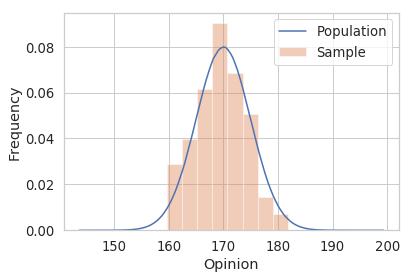

In [7]:
sns.distplot(population,kde=True,label="Population",norm_hist=True,hist=False)
sns.distplot(sample,kde=False,label="Sample",norm_hist=True)

plt.xlabel("Opinion")
plt.ylabel("Frequency")
plt.legend()

### We _always_ want to calculate the coefficients for the population, not for the sample. 
- We calculate the estimate for the sample + confidence Intervals
- Confidence intervals can be calculated numerically, or more robustly using bootstrapping
    - We have our sample (n values)
    - Do 10000 times: 
        - Take n values from the sample (with replacement)
        - Calculate the mean (or std)
    - Take the percentiles 2.5 and 97.5 of those 10000 values -> Those are your confidence intervals 
- Drawback of bootstrapping: It can be slow to get all those samples

Visualization: http://www.lock5stat.com/StatKey/bootstrap_1_quant/bootstrap_1_quant.html

Based on the central limit theorem: http://mfviz.com/central-limit/

Important: seaborn confidence intervals are based on bootstrapping!

In [8]:
import scikits.bootstrap as bootstrap

print(np.mean(sample),np.std(sample))

CIs = bootstrap.ci(sample, statfunction=np.mean,n_samples=10000)  
print('CI for mean with bootstrapping = ', CIs)

CIs = bootstrap.ci(sample, statfunction=np.median,n_samples=10000)  
print('CI for median with bootstrapping = ', CIs)

CIs = bootstrap.ci(sample, statfunction=np.std,n_samples=10000)  
print('CI for std with bootstrapping = ', CIs)

CIs = bootstrap.ci(sample, statfunction=inequality,n_samples=10000)  
print('CI for inequality (20/80) with bootstrapping = ', CIs)

CIs = bootstrap.ci(sample, statfunction=lambda x: inequality(x,0.9),n_samples=10000)  
print('CI for inequality (10/90) with bootstrapping = ', CIs)

CIs = bootstrap.ci(sample, statfunction=lambda x: inequality(x,0.99),n_samples=10000)   
print('CI for inequality (1/99) with bootstrapping = ', CIs)

169.57790880576317 4.613649576573387
CI for mean with bootstrapping =  [168.66649083 170.45782658]
CI for median with bootstrapping =  [169.06793361 170.65379423]
CI for std with bootstrapping =  [4.12956587 5.292679  ]
CI for inequality (20/80) with bootstrapping =  [0.26024679 0.26414813]
CI for inequality (10/90) with bootstrapping =  [0.11602569 0.11833985]
CI for inequality (1/99) with bootstrapping =  [0.01073205 0.01093656]


/home/jgarcia1/.local/lib/python3.5/site-packages/scikits/bootstrap/bootstrap.py:200: InstabilityWarning: Some values used extremal samples; results are probably unstable.
  warnings.warn("Some values used extremal samples; results are probably unstable.", InstabilityWarning)


## 1.1 Non-Representative samples because of undersampling)
- The sample may not be representative if you only study a handful of people (psychology, ehem...)
- The sample may not be representative if the distribution of the population is highly skewed (it's very unlikely that you select Bill Gates)

In [9]:
population = np.random.lognormal(mean=1,sigma=2,size=16000000)

_ = print_statistics(population)

Mean: 20.09
Median: 2.72
STD: 142.31
Inequality: Top 20%/80%: 7.108
Inequality: Top 10%/90%: 3.234
Inequality: Top 1%/99%: 0.593


In [10]:
sample = np.random.choice(population,size=385,replace=False)

_ = print_statistics(sample)

Mean: 21.28
Median: 2.13
STD: 82.48
Inequality: Top 20%/80%: 8.547
Inequality: Top 10%/90%: 3.577
Inequality: Top 1%/99%: 0.494


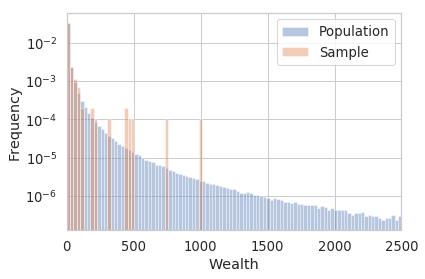

In [11]:
sns.distplot(population,kde=False,label="Population",norm_hist=True,bins=np.linspace(0,2500,100))
sns.distplot(sample,kde=False,label="Sample",norm_hist=True,bins=np.linspace(0,2500,100))

plt.xlabel("Wealth")
plt.ylabel("Frequency")
plt.xlim(0,2500)
plt.yscale("log")
plt.legend()

In [12]:
CIs = bootstrap.ci(sample, statfunction=np.mean,n_samples=100000)  
print('CI for mean with bootstrapping = ', CIs)
CIs = bootstrap.ci(sample, statfunction=np.median,n_samples=100000)  
print('CI for median with bootstrapping = ', CIs)
CIs = bootstrap.ci(sample, statfunction=np.std,n_samples=100000)  
print('CI for std with bootstrapping = ', CIs)
CIs = bootstrap.ci(sample, statfunction=inequality,n_samples=100000)  
print('CI for inequality (20/80) with bootstrapping = ', CIs)
CIs = bootstrap.ci(sample, statfunction=lambda x: inequality(x,0.9),n_samples=100000)  
print('CI for inequality (10/90) with bootstrapping = ', CIs)
CIs = bootstrap.ci(sample, statfunction=lambda x: inequality(x,0.99),n_samples=100000)   
print('CI for inequality (1/99) with bootstrapping = ', CIs)

CI for mean with bootstrapping =  [14.99109214 32.76798105]
CI for median with bootstrapping =  [1.75972419 2.87101795]
CI for std with bootstrapping =  [ 53.72380651 131.30376079]
CI for inequality (20/80) with bootstrapping =  [ 5.95454412 13.70199292]
CI for inequality (10/90) with bootstrapping =  [2.41489463 5.80085018]
CI for inequality (1/99) with bootstrapping =  [0.33901166 0.80036638]


# 2. Missing data
- Even if you have a nice representative sample you may have missing data
- Let's imagine we have a data of a survey, with age, income, education, political ideas, location, and if you will vote for Trump or Hillary.

## 2.1 Missing data mechanisms
We may have some missing values. Missing data mechanisms:
- 2.1.1 MCAR (missing completely at random), which means that we have a representative sample. 
    - OK
    - Missing value (y) neither depends on x (another variable) nor y
    - This for example could happen if during the survey collection there were some IT problems.
    - It is usually a **strong assumption** but it is usually made without consideration.
    - However imagine if young/rich/religious people are less likely to answer --> Then your data is MAR.
    - Usually in surveys you make sure you ask to a percentage of people of age and location that correspond with the real population. But you may be missing an important variable (for example US pollsters didn't ask for a representative sample in terms of education). 
    - We can either ignore the rows or impute the values based on people that did answer. 


- 2.1.2 MAR (missing at random), which means that we don't have a representative sample, but we can use another column to `impute` missing values. 
    - OK
    - Missing value (y) depends on x, but not y
    - Young/rich/religious people (x) may be less likely to answer about their voting preference (y)
    - We can correct the data by using other people that did answer. For instance, two people living in the same area, with the same age, income, education and political ideas are likely to vote similar, so if you only know how one of them intends to vote you can say that the other one will vote the same (there are methods for this, don't do it by hand!)
    - This is usually okay unless you have a weird distribution
 
- 2.1.3 MNAR (missing not at random), which means that we don't have a representative sample, and imputation is very very hard. This can happen for example if Trump voters are less likely to open the door, then they are not even in your sample.
    - Problem
    - The probability of a missing value (y) depends on the variable that is missing (y)
    - Trump voters (y) are less likely to answer about their voting preference (y)
    - We are in trouble and the methods to correct for this are way beyond the scope of the class (e.g. Heckman correction)
    - Impossible to verify unless you have some other dataset
    - Less of a problem if your missing variable (y) is correlated to some other variables (e.g. income, education, etc)
    
- Careful: Different variables can have different mechanism of missingness. Always ask yourself what could be causing the missingness.


## 2.2 Correcting for missing data
- 2.2.1 Ignore those values (only if your data is MCAR): Listwise Deletion (Complete Case Analysis)
- Impute those values (always better but more complicated)
    - 2.2.2 Single imputation: Problem: Usually reduces the variance or affects the correlation between variables
        - 2.2.2.1 Use the mean/median/mode as the value (only works "okayish" in MCAR)
        - 2.2.2.2 Use the mean/median/mode of the group as the value 
        - 2.2.2.3 Regression estimate or random forest (missForest)
        - 2.2.2.4 Use similar values (KNN in fancyimpute)
    - 2.2.3 Multiple imputation by chained equations (MICE): Similar to bootstrapping)

### Why do we care about missing values?
- To minimize biases and maximize the information available --> Find good estimates of our parameters


## We are going to be using a very bad distribution (extreme case, when we have more problems)

In [79]:
#Read our dataframe on wealth and income
population = read_data_ineq(N=1000000)

#Convert to a dataframe
population = pd.DataFrame(population,columns=["Wealth","Income"])

#Add random noise to income and wealth
population["Income"] = population["Income"] + 0.5*np.random.normal(0,(10**4.2+np.abs(population["Income"])))
population["Wealth"] = population["Wealth"] + 0.5*np.random.normal(0,(1E5+np.abs(population["Wealth"])))

population = population.loc[population["Wealth"]>1]
population = population.loc[population["Income"]>1]

#Print correlation
from scipy.stats import pearsonr
print("Correlation: ",pearsonr(population["Income"],population["Wealth"])[0])

population.head()

Correlation:  0.7455941698050293


,Wealth,Income
3,161145.037200,16718.048963
13,89092.288218,4089.291186
35,75206.917402,9414.627394
42,88961.761097,6499.584684
45,10277.622709,2925.252814


Text(0, 0.5, 'Frequency')

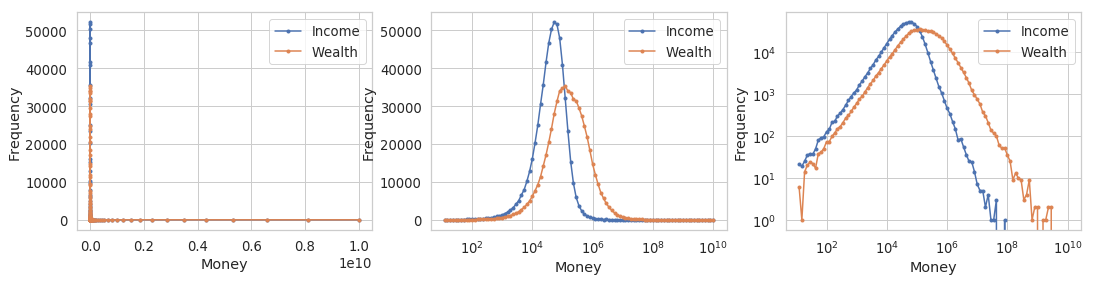

In [80]:
plt.figure(figsize=(18,4))
plt.subplot(131)
#For simplicity, get only the 40% of the population with no debts


values_i,bins = np.histogram(population["Income"],bins=np.logspace(1,10,100))
values_w,bins = np.histogram(population["Wealth"],bins=np.logspace(1,10,100))

plt.plot(bins[1:],values_i,".-",label="Income")
plt.plot(bins[1:],values_w,".-",label="Wealth")
plt.legend()
plt.xlabel("Money")
plt.ylabel("Frequency")


plt.subplot(132)
#Log scale in x-axis -> Should look normally distributed if the distribution is lognormal
plt.plot(bins[1:],values_i,".-",label="Income")
plt.plot(bins[1:],values_w,".-",label="Wealth")
plt.xscale("log")
plt.legend()
plt.xlabel("Money")
plt.ylabel("Frequency")


plt.subplot(133)
#Log-log scale > Should have a straight queue if the distribution is a power-law
plt.plot(bins[1:],values_i,".-",label="Income")
plt.plot(bins[1:],values_w,".-",label="Wealth")
plt.xscale("log")
plt.yscale("log")
plt.legend()
plt.xlabel("Money")
plt.ylabel("Frequency")

### Step 2: Get a sample

In [82]:
_ = print_statistics(population["Wealth"])

Mean: 486919.73
Median: 130519.80
STD: 7539785.94
Inequality: Top 20%/80%: 3.713
Inequality: Top 10%/90%: 1.944
Inequality: Top 1%/99%: 0.535


In [88]:
sample = population.sample(n=385)
_ = print_statistics(sample["Wealth"])

Mean: 346268.31
Median: 142076.54
STD: 709798.61
Inequality: Top 20%/80%: 2.231
Inequality: Top 10%/90%: 1.075
Inequality: Top 1%/99%: 0.209


In [91]:
sample = population.sample(n=100)
sample = sample.sort_values(by="Wealth")

_ = print_statistics(sample["Wealth"])

Mean: 478679.52
Median: 112215.61
STD: 1071856.04
Inequality: Top 20%/80%: 3.630
Inequality: Top 10%/90%: 1.633
Inequality: Top 1%/99%: 0.211


## 2.1 Missing data mechanisms

### 2.1.1 MCAR data
- Make wealth missing randomly

In [92]:
sample["Wealth_MCAR"] = sample["Wealth"].copy()
#Add 20% of missing values
sample.loc[np.random.random(len(sample))<0.2,"Wealth_MCAR"] = np.NaN
_ = print_statistics(sample["Wealth_MCAR"].dropna())

Mean: 468307.87
Median: 110233.55
STD: 1092744.84
Inequality: Top 20%/80%: 3.659
Inequality: Top 10%/90%: 1.685
Inequality: Top 1%/99%: 0.301


### 2.1.2 MAR data
- Make wealth missing when income is high

In [93]:
sample["Wealth_MAR"] = sample["Wealth"].copy()
#Add 20% of missing values
p=np.percentile(sample["Income"],60)
sample.loc[(sample["Income"] > p)&(np.random.random(len(sample))<0.5),"Wealth_MAR"] = np.NaN
_ = print_statistics(sample["Wealth_MAR"].dropna())

Mean: 428221.56
Median: 103335.49
STD: 1095726.29
Inequality: Top 20%/80%: 4.131
Inequality: Top 10%/90%: 2.109
Inequality: Top 1%/99%: 0.297


### 2.1.3 MNAR data
- Make wealth missing when wealth is high
- Good news: Imputation possible since income is correlated

In [94]:
sample["Wealth_MNAR"] = sample["Wealth"].copy()
#Add 20% of missing values
p=np.percentile(sample["Wealth"],60)
sample.loc[(sample["Wealth"] > p)&(np.random.random(len(sample))<0.5),"Wealth_MNAR"] = np.NaN
_ = print_statistics(sample["Wealth_MNAR"].dropna())

Mean: 339239.21
Median: 85401.37
STD: 1015930.51
Inequality: Top 20%/80%: 4.602
Inequality: Top 10%/90%: 2.462
Inequality: Top 1%/99%: 0.451


### 2.1.3 MNAR data 2 (Non-representative sample due to problems with the design)
- Make **observation** (person) missing when wealth is high
- Bad news: Impossible to verify unless you have some kind of aggregated data

In [95]:
N = len(population)
p = np.zeros(N)
p[:int(0.1*N)] = 0.01
p[int(0.1*N):int(0.25*N)] = 0.1
p[int(0.25*N):int(0.75*N)] = 0.2
p[int(0.75*N):int(0.9*N)] = 0.1
p[int(0.9*N):] = 0.01

sample_mncar2 = population.sample(n=100000,weights=p)
_ = print_statistics(sample_mncar2["Wealth"])

Mean: 222145.85
Median: 131880.90
STD: 1715676.13
Inequality: Top 20%/80%: 1.381
Inequality: Top 10%/90%: 0.680
Inequality: Top 1%/99%: 0.149


## 2.1 Types of missing data
Summary

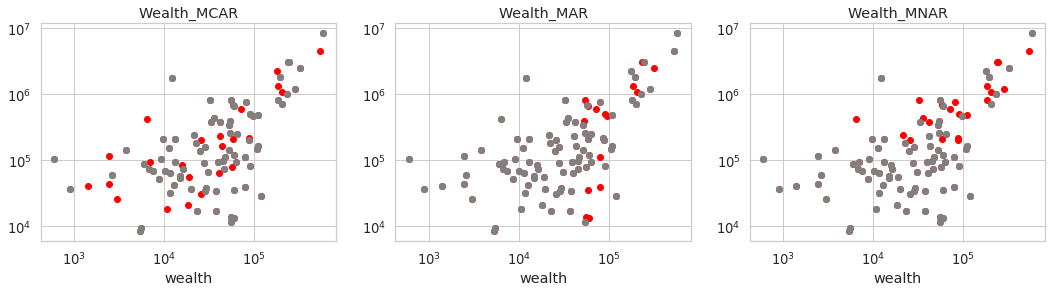

In [119]:
plt.figure(figsize=(18,4))

labels = ["Wealth",'Wealth_MCAR', 'Wealth_MAR', 'Wealth_MNAR']
i = 0
for col in labels[1:]:
    i+=1
    plt.subplot(1,3,i)
    plt.plot(sample["Income"],sample["Wealth"],"o",color="red")
    plt.plot(sample["Income"],sample[col],"o",color="gray")
    plt.title(col)
    
    plt.xlabel("income")
    plt.xlabel("wealth")
    
#     plt.xscale("log")
#     plt.yscale("log")

## Visualize missing data

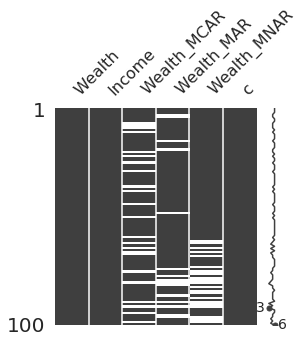

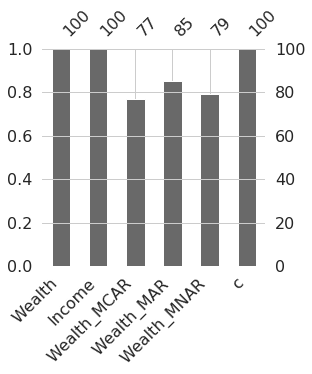

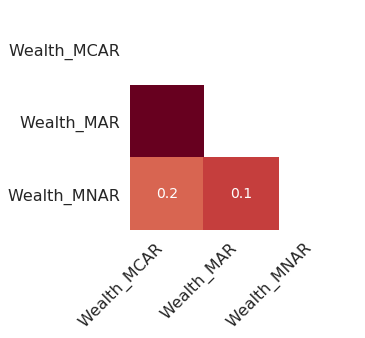

In [120]:
import missingno as msno

msno.matrix(sample,figsize=(4,4))

msno.bar(sample,figsize=(4,4))

msno.heatmap(sample,figsize=(4,4))

## 2.2 Correcting for missing data
- 2.2.1 Ignore those values (only if your data is MCAR): Listwise Deletion (Complete Case Analysis)
- Impute those values (always better but more complicated)
    - 2.2.2 Single imputation: Problem: Usually reduces the variance or affects the correlation between variables
        - 2.2.2.1 Use the mean/median/mode as the value (only works "okayish" in MCAR)
        - 2.2.2.2 Use the mean/median/mode of the group as the value 
        - 2.2.2.3 Regression estimate or random forest (missForest)
        - 2.2.2.4 Use similar values (KNN in fancyimpute)
    - 2.2.3 Multiple imputation by chained equations (MICE): Similar to bootstrapping)

### 2.2.1 List-wise deletion (ignoring the values)
- Only okay if the data is MCAR
- Reduces the amount of information available

In [121]:
labels = ['Wealth_MCAR', 'Wealth_MAR', 'Wealth_MNAR']
print("- {}: ${:2.0f}k".format("Original wealth",(sample["Wealth"]).mean()/1000))

for col in labels:
    data = sample.dropna(subset=[col])
    print("{}: ${:2.0f}k".format(col,(data[col]).mean()/1000))


- Original wealth: $479k
Wealth_MCAR: $468k
Wealth_MAR: $428k
Wealth_MNAR: $339k


### 2.2.2.1 Single imputation: Use the mean/median/mode as the value
- Reduces the variance
- Modifies the correlation
- You could add some noise to fix the variance, but the correlation would still be bad
- 2.2.2.2 Use the mean/median/mode of the group as the value (if we have for example data by city, we can do the imputation at the ctiy level)

- Original wealth: $479k
Wealth_MCAR (mean): $468k
Wealth_MAR (mean): $428k
Wealth_MNAR (mean): $339k


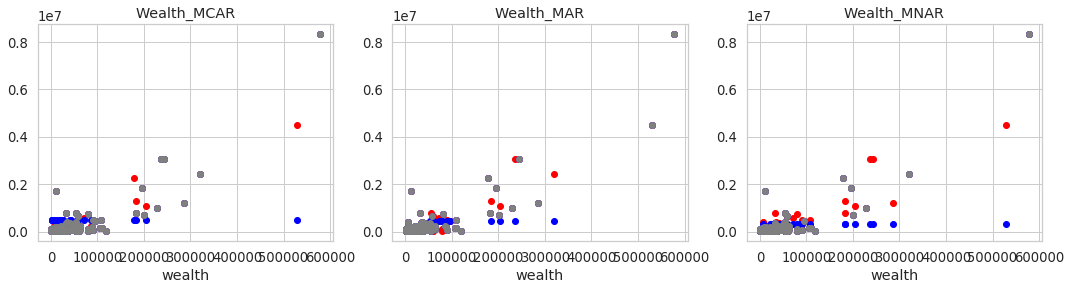

In [122]:
sample_mean = sample.fillna(sample.mean())
plt.figure(figsize=(18,4))

print("- {}: ${:2.0f}k".format("Original wealth",(sample["Wealth"]).mean()/1000))

labels = ["Wealth",'Wealth_MCAR', 'Wealth_MAR', 'Wealth_MNAR']
i = 0
for col in labels[1:]:
    i+=1
    plt.subplot(1,3,i)
    plt.plot(sample["Income"],sample["Wealth"],"o",color="red")
    plt.plot(sample_mean["Income"],sample_mean[col],"o",color="blue")
    plt.plot(sample["Income"],sample[col],"o",color="gray")
    plt.title(col)
    
    print("{} (mean): ${:2.0f}k".format(col,(sample_mean[col]).mean()/1000))
    
    plt.xlabel("income")
    plt.xlabel("wealth")
    
#     plt.xscale("log")
#     plt.yscale("log")

### 2.2.2.3 Regression estimate or random forest (missForest)
- Better, but still too optimistic and we do not know the uncertainty of our results
- Fails for outliers

In [123]:
#already installed,otherwise uncomment the line below
#!conda install --yes -c r rpy2  


import rpy2 
%load_ext rpy2.ipython
%R require("missForest")

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


array([1], dtype=int32)

In [124]:
#Don't worry about this
sample["c"] = np.random.randn(100)
sample.head()

,Wealth,Income,Wealth_MCAR,Wealth_MAR,Wealth_MNAR,c
119943,8396.830285,5326.499317,8396.830285,8396.830285,8396.830285,-0.176037
85722,9130.748348,5503.499068,9130.748348,9130.748348,9130.748348,0.357708
511842,11383.885998,55024.882303,11383.885998,11383.885998,11383.885998,1.783284
659683,13287.752240,59886.373106,13287.752240,NaN,13287.752240,-0.738130
566273,13632.689752,55060.444695,13632.689752,NaN,13632.689752,-0.277316


In [125]:
%%R -o sample_forest -i sample

sample[,c("c","Wealth_MCAR","Income")] <- missForest(sample[,c("c","Wealth_MCAR","Income")])$ximp
sample[,c("c","Wealth_MAR","Income")] <- missForest(sample[,c("c","Wealth_MAR","Income")])$ximp
sample[,c("c","Wealth_MNAR","Income")] <- missForest(sample[,c("c","Wealth_MNAR","Income")])$ximp

sample_forest <- sample

  missForest iteration 1 in progress...done!
  missForest iteration 2 in progress...done!
  missForest iteration 3 in progress...done!
  missForest iteration 1 in progress...done!
  missForest iteration 2 in progress...done!
  missForest iteration 3 in progress...done!
  missForest iteration 4 in progress...done!
  missForest iteration 1 in progress...done!
  missForest iteration 2 in progress...done!
  missForest iteration 3 in progress...done!
  missForest iteration 4 in progress...done!


- Original wealth: $479k
Wealth_MCAR (mean): $471k
Wealth_MAR (mean): $440k
Wealth_MNAR (mean): $398k


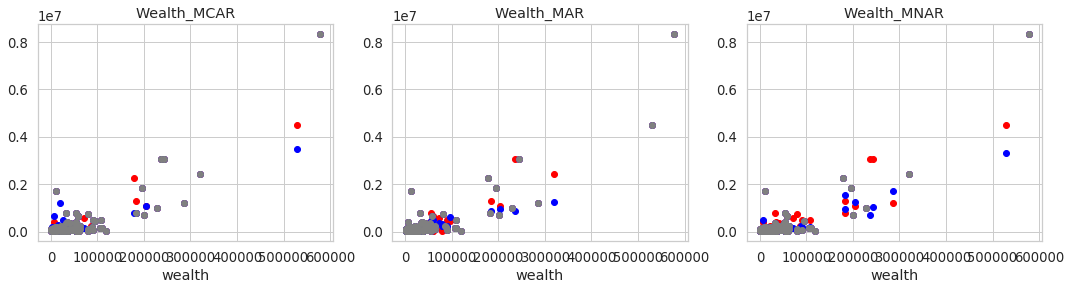

In [126]:
plt.figure(figsize=(18,4))

print("- {}: ${:2.0f}k".format("Original wealth",(sample["Wealth"]).mean()/1000))

labels = ["Wealth",'Wealth_MCAR', 'Wealth_MAR', 'Wealth_MNAR']
i = 0
for col in labels[1:]:
    i+=1
    plt.subplot(1,3,i)
    plt.plot(sample["Income"],sample["Wealth"],"o",color="red")
    plt.plot(sample_forest["Income"],sample_forest[col],"o",color="blue")
    plt.plot(sample["Income"],sample[col],"o",color="gray")
    plt.title(col)
    
    print("{} (mean): ${:2.0f}k".format(col,(sample_forest[col]).mean()/1000))
    
    plt.xlabel("income")
    plt.xlabel("wealth")
    
#     plt.xscale("log")
#     plt.yscale("log")

### 2.2.2.4 Use similar values (KNN in fancyimpute)
- Also good, but it is difficult to define what "similar" is
- Fails for outliers

(77, 6)
Imputing row 1/100 with 0 missing, elapsed time: 0.007
(85, 6)
Imputing row 1/100 with 0 missing, elapsed time: 0.006
(79, 6)
Imputing row 1/100 with 0 missing, elapsed time: 0.005
- Original wealth: $479k
Wealth_MCAR (mean): $489k
Wealth_MAR (mean): $443k
Wealth_MNAR (mean): $455k


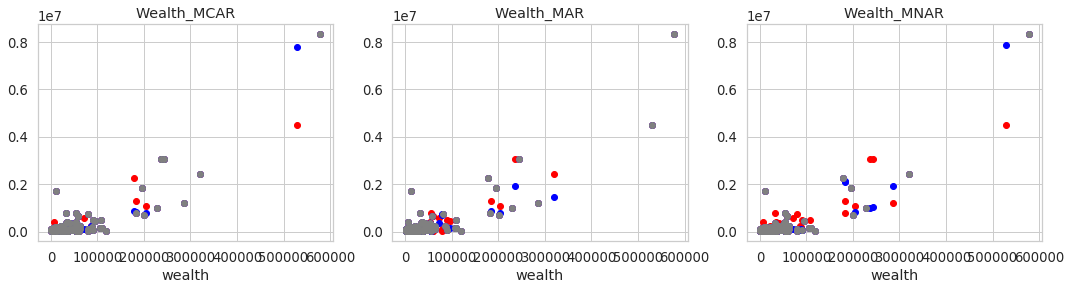

In [127]:
from fancyimpute import KNN
sample_knn = sample.copy()

for label in ['Wealth_MCAR', 'Wealth_MAR', 'Wealth_MNAR']:
    print(sample_knn.dropna(subset=[label]).shape)
    sample_knn.loc[:,[label,"Income"]] = KNN(k=3).fit_transform(sample_knn.loc[:,[label,"Income"]])

plt.figure(figsize=(18,4))

print("- {}: ${:2.0f}k".format("Original wealth",(sample["Wealth"]).mean()/1000))

labels = ["Wealth",'Wealth_MCAR', 'Wealth_MAR', 'Wealth_MNAR']
i = 0
for col in labels[1:]:
    i+=1
    plt.subplot(1,3,i)
    plt.plot(sample["Income"],sample["Wealth"],"o",color="red")
    plt.plot(sample_knn["Income"],sample_knn[col],"o",color="blue")
    plt.plot(sample["Income"],sample[col],"o",color="gray")
    plt.title(col)
    
    print("{} (mean): ${:2.0f}k".format(col,(sample_knn[col]).mean()/1000))
    
    plt.xlabel("income")
    plt.xlabel("wealth")
    
#     plt.xscale("log")
#     plt.yscale("log")

### 2.2.3 Multiple imputation by chained equations (MICE): Similar to bootstrapping)
- Impute many times the data with different models
- Analyze the imputed data
- Use it to calculate confidence intervals


####  We can use MICE (or IterativeImputer) from fancyimputem
- Calculate many samples and do it by hand

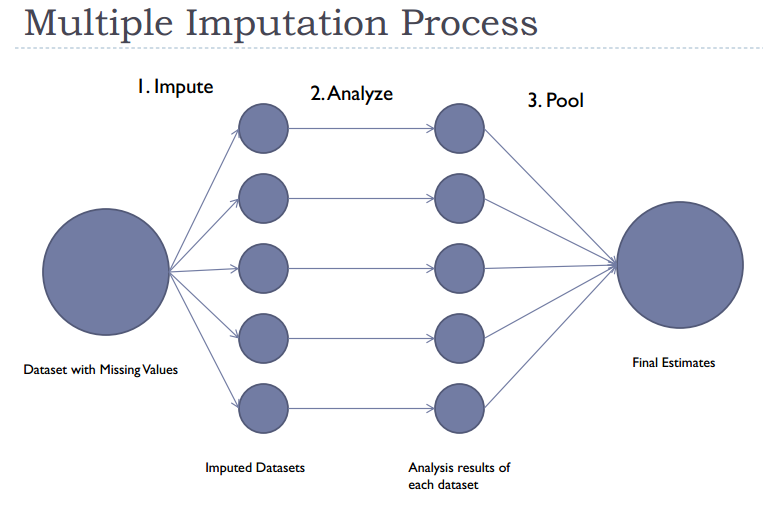

In [128]:
Image("images/mi.png")

- Original wealth: $479k
Wealth_MCAR (mean): $[419.4066 516.3281]k
Wealth_MAR (mean): $[463.7802 543.981 ]k
Wealth_MNAR (mean): $[475.9145 546.7084]k


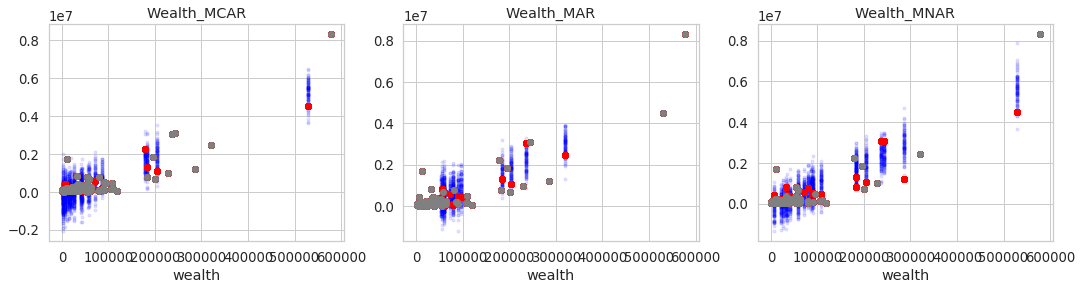

In [129]:
from fancyimpute import IterativeImputer
import statsmodels.formula.api as smf

sample_mice = sample.copy()
i = 0
plt.figure(figsize=(18,4))

print("- {}: ${:2.0f}k".format("Original wealth",(sample["Wealth"]).mean()/1000))

d = dict()
d2 = dict()
d3 = dict()


for label in ['Wealth_MCAR', 'Wealth_MAR', 'Wealth_MNAR']:
    val = []
    val2 = []
    val3 = []
    col = label
    i+=1
    plt.subplot(1,3,i)
    for j in range(100):
        sample_mice = sample.copy()
        sample_mice.loc[:,[label,"Income"]] = IterativeImputer(n_iter=10, sample_posterior=True, random_state=j).fit_transform(sample_mice.loc[:,[label,"Income"]].values)

        plt.plot(sample["Income"],sample["Wealth"],"o",color="red")
        
        plt.plot(sample_mice["Income"],sample_mice[col],".",color="blue",alpha=0.1)
        plt.plot(sample["Income"],sample[col],"o",color="gray")
        plt.title(col)
        
        val.append(sample_mice[col].mean())
        val2.append(inequality(sample_mice[col],f=.9))
        val3.append(smf.ols("{}~Income".format(label),data=sample_mice).fit().params[1])
    


      
    val = (np.array(val))
    val2 = (np.array(val2))
    val3 = (np.array(val3))
    
    
    d[label] = np.percentile(val,[2.5,97.5])
    d2[label] = np.percentile(val2,[2.5,97.5])
    d3[label] = np.percentile(val3,[2.5,97.5])
    
    print("{} (mean): ${}k".format(label,np.round(d[label],1)/1000))
    
    
    plt.xlabel("income")
    plt.xlabel("wealth")
    
#     plt.xscale("log")
#     plt.yscale("log")

####  We can use MICE from statsmodels
- For a regression

In [186]:
import statsmodels.formula.api as smf
from statsmodels.imputation import mice
import statsmodels.api as sm

imp = mice.MICEData(sample)

reg = smf.ols("Wealth~Income",data=sample).fit()

def boot_mean(values):
    return np.round(bootstrap.ci(values, statfunction=np.mean,n_samples=10000),0)
def boot_ineq(values):
    return np.round(bootstrap.ci(values, statfunction=lambda x: inequality(x,f=.9),n_samples=10000),2)

print("Truth: ", np.round(reg.params[1],2), 
      " Mean (BS): ${:2.0f}k".format((sample["Wealth"]).mean()/1000),
      " Ineq 10/90 (BS): {:2.2f}".format(inequality((sample["Wealth"]),f=.9)))
print()


for col in ["Wealth_MCAR","Wealth_MAR","Wealth_MNAR"]:
    labels = ["dropna","mean","forest","knn","mice statsmodels", "mice fancyimpute"]
    
    print(col)
    data = sample.dropna(subset=[col])
    reg = smf.ols("{}~Income".format(col),data=data).fit()
   
    print(labels.pop(0), np.round(reg.conf_int().loc["Income"].values,2), 
      " Mean (BS): ${}k".format(boot_mean(data[col]/1000)),
      " Ineq 10/90 (BS): {}".format(boot_ineq(data[col]),f=.9))
          
    
    for data in [sample_mean,sample_forest,sample_knn]:
        #The regression using the sample

        reg = smf.ols("{}~Income".format(col),data=data).fit()
        print(labels.pop(0), np.round(reg.conf_int().loc["Income"].values,2), 
      " Mean (BS): ${}k".format(boot_mean(data[col]/1000)),
      " Ineq 10/90 (BS): {}".format(boot_ineq(data[col]),f=.9))
        
    
    results = mice.MICE('{} ~ Income'.format(col), sm.OLS, imp).fit(10, 10)
    print(labels.pop(0), np.round(results.conf_int()[1],2))
    print(labels.pop(0),np.round(d3[col],2), " Mean: ${}k".format(np.round(d[col]/1000,0)),
      " Ineq 10/90: {}".format(np.round(d2[col],2)))
    print()

Truth:  9.79  Mean (BS): $479k  Ineq 10/90 (BS): 1.63

Wealth_MCAR
dropna [ 9.01 11.88]  Mean (BS): $[300. 898.]k  Ineq 10/90 (BS): [1.03 3.8 ]
mean [5.63 8.47]  Mean (BS): $[344. 784.]k  Ineq 10/90 (BS): [0.64 2.21]
forest [ 7.72 10.05]  Mean (BS): $[335. 795.]k  Ineq 10/90 (BS): [0.91 2.8 ]
knn [ 9.97 12.38]  Mean (BS): $[319. 874.]k  Ineq 10/90 (BS): [1.02 3.37]
mice statsmodels [6.35 9.63]
mice fancyimpute [ 9.67 11.06]  Mean: $[419. 516.]k  Ineq 10/90: [1.52 2.64]

Wealth_MAR
dropna [ 8.79 11.17]  Mean (BS): $[267. 800.]k  Ineq 10/90 (BS): [1.28 4.38]
mean [7.33 9.79]  Mean (BS): $[291. 768.]k  Ineq 10/90 (BS): [0.87 3.01]
forest [ 7.88 10.13]  Mean (BS): $[302. 748.]k  Ineq 10/90 (BS): [0.89 2.93]
knn [ 8.13 10.34]  Mean (BS): $[299. 755.]k  Ineq 10/90 (BS): [1.03 3.22]
mice statsmodels [ 7.5  10.51]
mice fancyimpute [ 9.55 10.36]  Mean: $[464. 544.]k  Ineq 10/90: [1.3  1.79]

Wealth_MNAR
dropna [ 9.56 12.3 ]  Mean (BS): $[196. 758.]k  Ineq 10/90 (BS): [1.36 6.25]
mean [4.79 7.62

## Important: Make sure you have missing values instead of "-9" or other strings in your file
- The way to do it is to explore the file and then read it:

pd.read_csv(filename,...,na_values=[`here the list of missing values`]

# 3. Dealing with outliers
In short:
- If the outlier is *obviously wrong* you should treat it as missing data. For instance if you record a value of 19 in a 0-10 scale (it was problably 1 or 9, but we don't know).
- If the outlier is *not obviously wrong", you should keep it. For instance if most people say 3 in a 0-10 scale but a couple say 9, then you need to keep it. You can use `robust` statistics, that are not so affected by outliers. 

See outliers: --> Distributions and pairplots


Read this:
http://www.theanalysisfactor.com/outliers-to-drop-or-not-to-drop/

# Example of code

### Read data

In [162]:
#Inclass exercises
df = pd.read_csv("data/impute_example.csv",sep="\t")
df = df.loc[df["Metropolitan areas"]!="Italy"]
df.head()

,C,METRO_ID,Metropolitan areas,LABOUR_PRODUCTIVITY,UNEMP_R,GDP_PC
0,IT,IT001,Rome,1.246225,1.153054,1.263583
1,IT,IT001,Rome,1.263464,1.041401,1.292440
2,IT,IT001,Rome,1.244960,0.827486,1.302868
3,IT,IT001,Rome,1.227114,0.837920,1.285412
4,IT,IT001,Rome,1.241025,0.779485,1.325299


### Visualize missing data

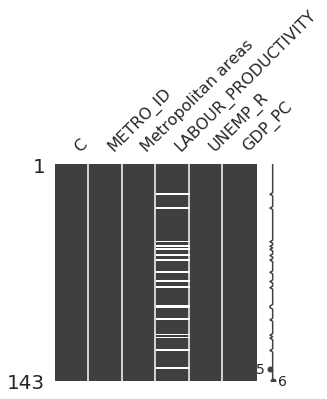

In [164]:
import missingno as msno

msno.matrix(df,figsize=(4,4))

### Find confidence intervals

In [165]:
#Find the confidence intervals of each variable (don't pass missing values!)
import scikits.bootstrap as bootstrap

for column in ["LABOUR_PRODUCTIVITY","UNEMP_R","GDP_PC"]:
    CIs = bootstrap.ci(df[column].dropna(), statfunction=np.mean,n_samples=10000)  
    print(column,CIs)



LABOUR_PRODUCTIVITY [0.98732763 1.04341788]
UNEMP_R [0.90798007 1.12423009]
GDP_PC [0.95575503 1.0552188 ]


### Impute using KNN (K-nearest neighbors)
- Disadvantage: Using categorical variables is hard

In [167]:
from fancyimpute import KNN
def knn_impute(data,variables,categorical_var=None,k=5):
    sample = data.copy()
    if categorical_var is None:
        sample[variables] = KNN(k=k).fit_transform(sample[variables])
        return data
    else:
        df_knns = []
        for g,sample_g in sample.groupby(categorical_var):
            try:
                sample_g[variables] = KNN(k=k).fit_transform(sample_g[variables])
            except:
                print(g, " not missing any")
            df_knns.append(sample_g)

        return pd.concat(df_knns)

In [178]:
df_filled = knn_impute(df,["LABOUR_PRODUCTIVITY","UNEMP_R","GDP_PC"])
CIs = bootstrap.ci(df_filled["LABOUR_PRODUCTIVITY"].dropna(), statfunction=np.mean,n_samples=10000)  
print("Mean of Labour productivity",np.mean(df_filled["LABOUR_PRODUCTIVITY"]))
print(CIs)


Imputing row 1/143 with 0 missing, elapsed time: 0.015
Imputing row 101/143 with 0 missing, elapsed time: 0.016
Mean of Labour productivity 1.0150968358458483
[0.98801732 1.04317513]


### Impute using missForest
- Disadvantage: Calling R from Python makes the code a bit harder

In [243]:
#Complete with missForest (uses python)

#already installed,otherwise uncomment the line below
#!conda install --yes -c r rpy2  
import rpy2 
%load_ext rpy2.ipython
%R require("missForest")

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


array([1], dtype=int32)

In [188]:
%%R -o df_forest -i df

#Convert categorical variables to factors (if we have categorical variables)
df[,c("Metropolitan.areas")] <- factor(df[,c("Metropolitan.areas")])

#impute
imp <- missForest(df[,c("Metropolitan.areas","LABOUR_PRODUCTIVITY","UNEMP_R","GDP_PC")],variablewise=TRUE)

#copy the df
df_forest = df
df_forest[,c("Metropolitan.areas","LABOUR_PRODUCTIVITY","UNEMP_R","GDP_PC")] = imp$ximp

#print error rates
print(imp$OOBerror)

  missForest iteration 1 in progress...done!
  missForest iteration 2 in progress...done!
  missForest iteration 3 in progress...done!
        PFC         MSE         MSE         MSE 
0.000000000 0.001001968 0.000000000 0.000000000 


In [189]:
CIs = bootstrap.ci(df_forest["LABOUR_PRODUCTIVITY"].dropna(), statfunction=np.mean,n_samples=10000)  
print("Mean of Labour productivity",np.mean(df_forest["LABOUR_PRODUCTIVITY"]))
print(CIs)

Mean of Labour productivity 1.0073600441888704
[0.9810418  1.03376702]


### Impute using Multiple imputation
- Disadvantage: Needs a function to aggregate the results

In [179]:
from fancyimpute import IterativeImputer
import statsmodels.formula.api as smf

def agg(data):
    #e.g. for the mean
    return [data["LABOUR_PRODUCTIVITY"].mean()]
    
#     #e.g. for the coefficient in the regression
#     return smf.ols("UNEMP_R~LABOUR_PRODUCTIVITY+GDP_PC"".format(label),data=sample_mice).fit().params


def mice_impute_agg(data,variables,function,repetitions=100):
    values = []
    for j in range(repetitions):
        sample = data.copy()
        sample[variables] = IterativeImputer(n_iter=10, sample_posterior=True, random_state=j).fit_transform(sample[variables])
        values.append(function(sample))
    values = np.array(values)
    return np.percentile(values,[2.5,97.5])


df_mean = mice_impute_agg(df,["LABOUR_PRODUCTIVITY","UNEMP_R","GDP_PC"],function=agg)
print("Mean of Labour productivity",df_mean)

Mean of Labour productivity [1.00479728 1.0109559 ]


### Regression using Multiple imputation
- You could also use bootstrapping using one of the other methods

In [181]:
import warnings
warnings.filterwarnings('ignore')

In [182]:
from statsmodels.imputation import mice
import statsmodels.api as sm

#micedata doesn't like strings, so we keep a code for each city
df["ID"] = df["METRO_ID"].str[2:].astype(int)

imp = mice.MICEData(df[["UNEMP_R","LABOUR_PRODUCTIVITY","GDP_PC"]])
reg = mice.MICE('UNEMP_R ~ LABOUR_PRODUCTIVITY + GDP_PC', sm.OLS, imp).fit(10, 100)

#fmi =  fraction of missing information
print(reg.summary())

                               Results: MICE
Method:                       MICE            Sample size:             143 
Model:                        OLS             Scale                    0.09
Dependent variable:           UNEMP_R         Num. imputations         100 
---------------------------------------------------------------------------
                     Coef.  Std.Err.    t     P>|t|   [0.025  0.975]  FMI  
---------------------------------------------------------------------------
Intercept            0.6425   0.2504   2.5656 0.0103  0.1517  1.1333 0.0429
LABOUR_PRODUCTIVITY  4.2234   0.4621   9.1387 0.0000  3.3176  5.1292 0.0434
GDP_PC              -3.8609   0.2429 -15.8927 0.0000 -4.3370 -3.3847 0.0381



# Inclass exercise:
- Do the same for the other dataset

In [ ]:
#Imports that you need
from fancyimpute import KNN,IterativeImputer
import scikits.bootstrap as bootstrap
from statsmodels.imputation import mice
import statsmodels.api as sm
import statsmodels.formula.api as smf

import rpy2 
%load_ext rpy2.ipython
%R require("missForest")

#For KNN imputation
def knn_impute(data,variables,categorical_var=None,k=5):
    sample = data.copy()
    if categorical_var is None:
        sample[variables] = KNN(k=k).fit_transform(sample[variables])
        return data
    else:
        df_knns = []
        for g,sample_g in sample.groupby(categorical_var):
            try:
                sample_g[variables] = KNN(k=k).fit_transform(sample_g[variables])
            except:
                print(g, " not missing any")
            df_knns.append(sample_g)

        return pd.concat(df_knns)
    
#For MICE imputation
def agg(data):
    #e.g. for the mean
    return data["LABOUR_PRODUCTIVITY"].mean()
    
#     #e.g. for the coefficient in the regression
#     return smf.ols("UNEMP_R~LABOUR_PRODUCTIVITY+GDP_PC"".format(label),data=sample_mice).fit().params[1]


def mice_impute_agg(data,variables,function,repetitions=100):
    values = []
    for j in range(repetitions):
        sample = data.copy()
        sample[variables] = IterativeImputer(n_iter=10, sample_posterior=True, random_state=j).fit_transform(sample[variables])
        values.append(function(sample))
    values = np.array(values)
    return np.percentile(values,[2.5,97.5])


In [ ]:
#Read the data of Spain (DONE)
df = pd.read_csv("data/impute_example2.csv",sep="\t")
df = df.loc[df["Metropolitan areas"]!="Spain"]
df.head()

In [ ]:
#Impute using KNN (fancyimpute)
df_knn = 

In [ ]:
#Impute using missForest

In [ ]:
%%R -o df_forest -i df

In [ ]:
#Merge df_knn and df_forest to see how the imputation worked, use the columns ["Metropolitan areas","UNEMP_R","GDP_PC"] 
#for the merging, those columns didn't have missing values so they will be the same for both
df_merged  = pd.merge(...,...,on=["Metropolitan areas","UNEMP_R","GDP_PC"])
df_merged.head()

In [ ]:
#Plot "LABOUR_PRODUCTIVITY_x" vs "LABOUR_PRODUCTIVITY_y"

In [ ]:
#Impute using MICE to calculate the maximum of "LABOUR_PRODUCTIVITY"

#Here is the aggregation function
def agg(data):
    return data["LABOUR_PRODUCTIVITY"].max()

In [ ]:
#Impute using MICE and create the regression